In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

from innvestigator import InnvestigateModel
from inverter_util import Flatten
import sys
sys.path.append("..")

import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import argparse
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
from VGG_16 import VGG16
import pickle

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
batch_size = 2560
transform_train = transforms.Compose([
#             transforms.RandomCrop(32, padding=4),
#             transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
    ])
transform_test = transforms.Compose([
        transforms.ToTensor()
])
train_data = torchvision.datasets.SVHN(
        root = './data/svhn',
        split = 'train',
        transform = transform_train,
        download = False
)
test_data = torchvision.datasets.SVHN(
        root = './data/svhn',
        split = 'test',
        transform = transform_test,
        download = False)
train_loader = Data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)
test_loader = Data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

def pick_neurons_layer(relev, per=0.1): 
    rel = torch.sum(relev, [2, 3])
    _, units = torch.topk(rel, round(per*rel.size(1)), dim=1)
    print(units.shape)
    return units.numpy()

In [ ]:
seeds = [32]
dropouts = [True]

classes = list(range(10))

path_class = {}
for i in classes:
    path_class[i] = {}

with torch.no_grad():
    for seed in seeds:
        for dropout in dropouts:
            model = VGG16(num_classes=10)
            if dropout:
                model_path = "../vgg_seed" + str(seed) + "_dropout.pkl"
            else:
                model_path = "../vgg_seed" + str(seed) + "_nodropout.pkl"
            checkpoint = torch.load(model_path)
            model.load_state_dict(checkpoint)
            model = model.cuda()
            model.eval()
                        # Convert to innvestigate model
            inn_model = InnvestigateModel(model, lrp_exponent=2,
                                          method="e-rule",
                                          beta=.5)
            for i, (data, target) in enumerate(train_loader):

                print("index:", i)

                data, target = data.cuda(), target.cuda()
                batch_size = int(data.size()[0])

                model_prediction, _ , true_relevance = inn_model.innvestigate(in_tensor=data)
                
                _, train_pred_y = model_prediction.max(1)
                if i == 0:
                    labels = train_pred_y
                labels = torch.cat((labels, train_pred_y), 0)

                if i == 0:
                    relev = true_relevance
                else:
                    for l in range(len(relev)):
                        relev[l] = torch.cat((relev[l], true_relevance[l]), 0)
                        
            
            pers = [0.1, 1.0]
            for per in pers:
                sample_neurons = {}
                for layer in range(len(relev)):
                    true_layer = 12-layer
                    r = relev[true_layer]
                    units = pick_neurons_layer(r, per)
                    for i in range(units.shape[0]):
                        if layer == 0:
                            sample_neurons[i] = []
                        sample_neurons[i].append(units[i])
                if dropout:
                    save_path = "./lrp_path_" + str(per) + "_seed" + str(seed) + "_train_SVHN" + ".pkl"
                    
                else:
                    save_path = "./lrp_path_" + str(per) + "_seed" + str(seed) + "_train_nodropout_SVHN" 
                    + ".pkl"
                    
                labels_path = "../paths/svhn_labels_seed32.pkl"
                output = open(save_path, 'wb')
                pickle.dump(sample_neurons, output) 
                labels_out = open(labels_path, 'wb')
                pickle.dump(labels, labels_out) 
print("done")

index: 0
index: 1
index: 2
index: 3
index: 4
index: 5
index: 6
index: 7
index: 8
index: 9


In [7]:
seeds = [32]
dropouts = [True]

classes = list(range(10))

path_class = {}
for i in classes:
    path_class[i] = {}

with torch.no_grad():
    for seed in seeds:
        for dropout in dropouts:
            model = VGG16(num_classes=10)
            if dropout:
                model_path = "../vgg_seed" + str(seed) + "_dropout.pkl"
            else:
                model_path = "../vgg_seed" + str(seed) + "_nodropout.pkl"
            checkpoint = torch.load(model_path)
            model.load_state_dict(checkpoint)
            model = model.cuda()
            model.eval()
                        # Convert to innvestigate model
            inn_model = InnvestigateModel(model, lrp_exponent=2,
                                          method="e-rule",
                                          beta=.5)
            for i, (data, target) in enumerate(test_loader):

                print("index:", i)

                data, target = data.cuda(), target.cuda()
                batch_size = int(data.size()[0])

                model_prediction, _ , true_relevance = inn_model.innvestigate(in_tensor=data)
                
                _, train_pred_y = model_prediction.max(1)
                if i == 0:
                    labels = train_pred_y
                else:
                    labels = torch.cat((labels, train_pred_y), 0)

                if i == 0:
                    relev = true_relevance
                else:
                    for l in range(len(relev)):
                        relev[l] = torch.cat((relev[l], true_relevance[l]), 0)
                        
            
            pers = [0.1, 1.0]
            for per in pers:
                sample_neurons = {}
                for layer in range(len(relev)):
                    true_layer = 12-layer
                    r = relev[true_layer]
                    units = pick_neurons_layer(r, per)
                    for i in range(units.shape[0]):
                        if layer == 0:
                            sample_neurons[i] = []
                        sample_neurons[i].append(units[i])
                if dropout:
                    save_path = "./lrp_path_" + str(per) + "_seed" + str(seed) + "_test_SVHN" + ".pkl"
                    
                else:
                    save_path = "./lrp_path_" + str(per) + "_seed" + str(seed) + "_test_nodropout_SVHN" 
                    + ".pkl"
                    
                labels_path = "../paths/svhn_labels_seed32_test.pkl"
                output = open(save_path, 'wb')
                pickle.dump(sample_neurons, output) 
                labels_out = open(labels_path, 'wb')
                pickle.dump(labels, labels_out) 
print("done")

index: 0
index: 1
index: 2
index: 3
index: 4
index: 5
index: 6
index: 7
index: 8
index: 9
index: 10
torch.Size([26032, 6])
torch.Size([26032, 6])
torch.Size([26032, 13])
torch.Size([26032, 13])
torch.Size([26032, 26])
torch.Size([26032, 26])
torch.Size([26032, 26])
torch.Size([26032, 51])
torch.Size([26032, 51])
torch.Size([26032, 51])
torch.Size([26032, 51])
torch.Size([26032, 51])
torch.Size([26032, 51])
torch.Size([26032, 64])
torch.Size([26032, 64])
torch.Size([26032, 128])
torch.Size([26032, 128])
torch.Size([26032, 256])
torch.Size([26032, 256])
torch.Size([26032, 256])
torch.Size([26032, 512])
torch.Size([26032, 512])
torch.Size([26032, 512])
torch.Size([26032, 512])
torch.Size([26032, 512])
torch.Size([26032, 512])
done


In [ ]:
model.eval()
total = 0
with torch.no_grad():
    for test_step, (val_x, val_y) in enumerate(test_loader):
        print("step:", test_step)
        val_x = val_x.cuda()
        val_y = val_y.cuda()
        val_output = model(val_x)
        _, val_pred_y = val_output.max(1)
        if test_step == 0:
            correct = val_pred_y.eq(val_y).sum().item()
        else:
            correct += val_pred_y.eq(val_y).sum().item()
        total += val_y.size(0)
result = float(correct) * 100.0 / float(total)
print(result)

In [11]:
 for i, (data, target) in enumerate(test_loader):
    
    print("index:", i)

    data, target = data.cuda(), target.cuda()
    batch_size = int(data.size()[0])

    model_prediction, _ , true_relevance = inn_model.innvestigate(in_tensor=data)
    
    if i == 0:
        relev = true_relevance
    else:
        for l in range(len(relev)):
            relev[l] = torch.cat((relev[l], true_relevance[l]), 0)

print("done")
print(len(relev))

index: 0
index: 1
index: 2
index: 3
done
13


In [13]:
pers = [0.01, 0.03, 0.05, 0.1]
for per in pers:
    sample_neurons = {}
    for layer in range(len(relev)):
        true_layer = 12-layer
        r = relev[true_layer]
        units = pick_neurons_layer(r, per)
        for i in range(units.shape[0]):
            if layer == 0:
                sample_neurons[i] = []
            sample_neurons[i].append(units[i])

    save_path = "./lrp_path_" + str(per) + "_seed" + str(seed) +  "_test.pkl"
    output = open(save_path, 'wb')
    pickle.dump(sample_neurons, output)  
print("done")

torch.Size([10000, 1])
torch.Size([10000, 1])
torch.Size([10000, 1])
torch.Size([10000, 1])
torch.Size([10000, 3])
torch.Size([10000, 3])
torch.Size([10000, 3])
torch.Size([10000, 5])
torch.Size([10000, 5])
torch.Size([10000, 5])
torch.Size([10000, 5])
torch.Size([10000, 5])
torch.Size([10000, 5])
torch.Size([10000, 2])
torch.Size([10000, 2])
torch.Size([10000, 4])
torch.Size([10000, 4])
torch.Size([10000, 8])
torch.Size([10000, 8])
torch.Size([10000, 8])
torch.Size([10000, 15])
torch.Size([10000, 15])
torch.Size([10000, 15])
torch.Size([10000, 15])
torch.Size([10000, 15])
torch.Size([10000, 15])
torch.Size([10000, 3])
torch.Size([10000, 3])
torch.Size([10000, 6])
torch.Size([10000, 6])
torch.Size([10000, 13])
torch.Size([10000, 13])
torch.Size([10000, 13])
torch.Size([10000, 26])
torch.Size([10000, 26])
torch.Size([10000, 26])
torch.Size([10000, 26])
torch.Size([10000, 26])
torch.Size([10000, 26])
torch.Size([10000, 6])
torch.Size([10000, 6])
torch.Size([10000, 13])
torch.Size([10000,

In [8]:
batch_size = 2560
attack = "pgd"
seed = 32
model = VGG16(num_classes=10)

model_path = "../vgg_seed" + str(seed) + "_dropout.pkl"

checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint)
model = model.cuda()
model.eval()

inn_model = InnvestigateModel(model, lrp_exponent=2,
                                          method="e-rule",
                                          beta=.5)

def read_data_label(data_path, label_path):
    with open(data_path, 'rb') as fr:
        test_data = pickle.load(fr)
        size = len(test_data)
    with open(label_path, 'rb') as fr:
        test_label = pickle.load(fr)
    return test_data, test_label, size

def pick_neurons_layer(relev, per=0.1): 
    rel = torch.sum(relev, [2, 3])
    _, units = torch.topk(rel, round(per*rel.size(1)), dim=1)
    print(units.shape)
    return units.numpy()

if attack == "pgd":
    test_data_path = "../data/adversarial_samples/Vanilla/pgd/test_adv(eps_0.031).pkl"
    test_label_path = "../data/adversarial_samples/Vanilla/pgd/test_label.pkl"
    test_data, test_label, size = read_data_label(test_data_path, test_label_path)
    dataset = Data.TensorDataset(test_data, test_label)
    
data_loader = Data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

for i, (data, target) in enumerate(data_loader):
    
    print("index:", i)

    data, target = data.cuda(), target.cuda()
    batch_size = int(data.size()[0])

    model_prediction, _ , true_relevance = inn_model.innvestigate(in_tensor=data)
    _, train_pred_y = model_prediction.max(1)
    
    if i == 0:
        labels = train_pred_y
    else:
        labels = torch.cat((labels, train_pred_y), 0)
        
    if i == 0:
        relev = true_relevance
    else:
        for l in range(len(relev)):
            relev[l] = torch.cat((relev[l], true_relevance[l]), 0)

print("done")
print(len(relev))

pers = [0.1, 1.0]
for per in pers:
    sample_neurons = {}
    for layer in range(len(relev)):
        true_layer = 12-layer
        r = relev[true_layer]
        units = pick_neurons_layer(r, per)
        for i in range(units.shape[0]):
            if layer == 0:
                sample_neurons[i] = []
            sample_neurons[i].append(units[i])
            
    save_path = "./lrp_path_" + str(per) + "_seed" + str(seed) + "_adv.pkl"
    
    labels_path = "../paths/svhn_labels_seed32_adv.pkl"
    output = open(save_path, 'wb')
    pickle.dump(sample_neurons, output) 
    labels_out = open(labels_path, 'wb')
    pickle.dump(labels, labels_out)
print("done")

index: 0
index: 1
index: 2
index: 3
done
13
torch.Size([10000, 6])
torch.Size([10000, 6])
torch.Size([10000, 13])
torch.Size([10000, 13])
torch.Size([10000, 26])
torch.Size([10000, 26])
torch.Size([10000, 26])
torch.Size([10000, 51])
torch.Size([10000, 51])
torch.Size([10000, 51])
torch.Size([10000, 51])
torch.Size([10000, 51])
torch.Size([10000, 51])
torch.Size([10000, 64])
torch.Size([10000, 64])
torch.Size([10000, 128])
torch.Size([10000, 128])
torch.Size([10000, 256])
torch.Size([10000, 256])
torch.Size([10000, 256])
torch.Size([10000, 512])
torch.Size([10000, 512])
torch.Size([10000, 512])
torch.Size([10000, 512])
torch.Size([10000, 512])
torch.Size([10000, 512])
done


<PIL.Image.Image image mode=RGB size=32x32 at 0x7F627AD95A10>


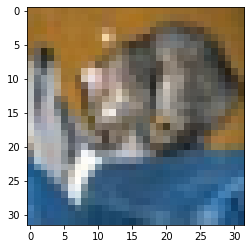

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from innvestigator import InnvestigateModel
from inverter_util import Flatten
import sys
sys.path.append("..")

import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import argparse
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
from VGG_16 import VGG16
import pickle

transform_test = transforms.Compose([
        transforms.ToTensor()
])
test_data = torchvision.datasets.CIFAR10(
        root = './data/cifar-10',
        train = False,
#         transform = transform_test,
        download = False)
print(test_data[0][0])
plt.imshow(test_data[0][0])
plt.show()



<PIL.Image.Image image mode=RGB size=32x32 at 0x7F5FAE5E4A50>


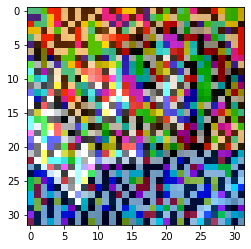

In [13]:
from PIL import Image

adv_data_path = "../adv_samples/adv_{}_cifar10_samples.npy".format("pgd")
adv_label_path = "../adv_samples/adv_{}_cifar10_labels.npy".format("fgsm")

test_data = torch.FloatTensor(np.load(adv_data_path).transpose(0,3,1,2)*255)
# dataset = Data.TensorDataset(test_data, test_label)
# a = Image.fromarray(test_data[0], mode='RGB')
a = transforms.ToPILImage()(test_data[0])
print(a)
plt.imshow(a)
plt.show()